Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum
from libs.duto_casadi import *
from libs.compressor_class import *
from libs.compression import *


In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real

# Número de nós (comprimento de self.l)

comp = CompressorClass()
compressor = compression(gas, comp, visc)

0.99365 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531123, 0.006138982539123434, 0.0015095858702762542, 0.0003019171740552508, 0.0003019171740552508, 0.0005535148191012933, 0.0004025562320736678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003019171740552508, 0.0, 0.0008051124641473356, 0.0]


In [3]:
# def erro_w0(w0_guess, duto, T0, V0, w_final_desejado):
#     w0_guess = float(np.atleast_1d(w0_guess)[0])  # garante escalar puro
#     y0 = [float(T0), float(V0), float(w0_guess)]
    
#     sol = solve_ivp(
#         lambda x, y: duto.estacionario(x, y),
#         [0.0, duto.Lc],
#         y0,
#         method="RK45",
#         rtol=1e-9,
#         atol=1e-12
#     )
#     w_final_calc = float(sol.y[2, -1])
#     return w_final_calc - w_final_desejado


# # condições conhecidas
# T_init = 330 
# P_init = 8400
# gas_init = gas.copy_change_conditions(T_init, P_init, None, 'gas')
# V_init = gas_init.V   # Volume específico de entrada    
        
# #saída [ | | | | |] => saída =>
  
# Q_out = 2 # [m³/s]
# A = np.pi * (D**2) / 4  # Área da seção transversal do duto
# w_final_desejado = Q_out / A
# print(w_final_desejado)
# # chute inicial para w0
# w0_guess = 17

# y_init = [T_init, V_init, w0_guess]

# print(meu_duto.estacionario(0, y_init))

# w0_sol, info, ier, msg = fsolve(
#     erro_w0,
#     [w0_guess],
#     args=(meu_duto, T_init, V_init, w_final_desejado),
#     xtol=1e-12,     # tolerância na solução (variáveis)
#     full_output=True
# )
# print(w0_sol)

In [4]:
from scipy.optimize import fsolve
import numpy as np

# --- Entradas conhecidas ---
u0 = 700
m_dot = 36
# --- Função residual (só para as variáveis livres) ---
def algebraic_residual(z_free, u, compressor):
    """
    Calcula o residual das equações algébricas do compressor
    com T2 e V2 fixos.
    """
    z_full = [z_free[0], z_free[1],
              z_free[2], z_free[3],
              z_free[4], z_free[5],
              z_free[6], z_free[7],
              z_free[8]]
    
    params = [u, m_dot/4, 4000, 300]  
    res = compressor.character_dae(z_full, params)
    return np.array(res).flatten()

Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(
    compressor, m=m_dot/4, N=u0, Gi_1=gas
)

z_guess = [Gimp.T, Gimp.V, Gdif.T, Gdif.V, G2s.T, G2s.V, G2.T, G2.V, gas.V]


# --- Resolve as equações algébricas ---
z_free_sol = fsolve(algebraic_residual, z_guess, args=(u0, compressor))

# Reconstrói o vetor completo com T2, V2 fixos
z_sol = [z_free_sol[0], z_free_sol[1],
         z_free_sol[2], z_free_sol[3],
         z_free_sol[4], z_free_sol[5],
         z_free_sol[6], z_free_sol[7],
         z_free_sol[8]]

print("Solução das variáveis algébricas:")
print(z_sol)

Solução das variáveis algébricas:
[np.float64(320.96133173352314), np.float64(0.4833304429738819), np.float64(320.3585160045963), np.float64(0.4951168340183965), np.float64(338.8953958002689), np.float64(0.3550651906746983), np.float64(344.3835704373237), np.float64(0.3627709765888745), np.float64(0.583790379032516)]


In [5]:
gas_p = gas.copy_change_conditions(z_sol[6], None, z_sol[7], 'gas')
meu_duto = duto(gas=gas_p, visc=visc, Lc=200000, D=D)
n_nodes = len(meu_duto.l)
A = np.pi * (D**2) / 4  
MM = gas_p.mixture.MM_m  
v_kg = z_sol[7] / MM
rho = 1 / v_kg
w_teste = m_dot/(A * rho)
y0 = [z_sol[6], z_sol[7], w_teste]


x_avaliar = meu_duto.l  

sol_estc = solve_ivp(
    lambda x, y: meu_duto.estacionario(x, y),
    [0.0, meu_duto.Lc],
    y0,
    t_eval=x_avaliar,
    method='RK45',
    rtol=1e-9,
    atol=1e-12
)

T_sol_estc = sol_estc.y[0]
V_sol_estc = sol_estc.y[1]
w_sol_estc = sol_estc.y[2]
P_sol_estc = []

for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)




# print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
# print("-"*45)

# for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
#     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.6f}")

In [11]:
from scipy.optimize import fsolve
import numpy as np

# --- Entradas conhecidas ---
gas_temp = gas.copy_change_conditions(sol_estc.y[0, -1], None, sol_estc.y[1, -1], 'gas')
u0 = 700
m_dot_duto_2 = sol_estc.y[2, -1]*rho*A
# --- Função residual (só para as variáveis livres) ---
def algebraic_residual2(z_free, u, compressor):
    """
    Calcula o residual das equações algébricas do compressor
    com T2 e V2 fixos.
    """
    z_full = [z_free[0], z_free[1],
              z_free[2], z_free[3],
              z_free[4], z_free[5],
              z_free[6], z_free[7],
              z_free[8]]
    
    params = [u, m_dot_duto_2/4, gas_temp.P, sol_estc.y[0, -1]]  
    res = compressor.character_dae(z_full, params)
    return np.array(res).flatten()

Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(
    compressor, m=m_dot/4, N=u0, Gi_1=gas
)

z_guess_duto2 = [Gimp.T, Gimp.V, Gdif.T, Gdif.V, G2s.T, G2s.V, G2.T, G2.V, gas.V]


# --- Resolve as equações algébricas ---
z_free_sol_duto2 = fsolve(algebraic_residual2, z_guess_duto2, args=(u0, compressor))

# Reconstrói o vetor completo com T2, V2 fixos
z_sol_duto2 = [z_free_sol_duto2[0], z_free_sol_duto2[1],
         z_free_sol_duto2[2], z_free_sol_duto2[3],
         z_free_sol_duto2[4], z_free_sol_duto2[5],
         z_free_sol_duto2[6], z_free_sol_duto2[7],
         z_free_sol_duto2[8]]

print("Solução das variáveis algébricas:")
print(z_sol_duto2)

Solução das variáveis algébricas:
[np.float64(306.84540556000707), np.float64(0.38037373152100273), np.float64(306.11210475416146), np.float64(0.3888537499740668), np.float64(350.65471853132914), np.float64(0.17827949413660357), np.float64(355.2166029021838), np.float64(0.18171308842681522), np.float64(0.4560426014571233)]


In [13]:
gas_p_2 = gas.copy_change_conditions(z_sol_duto2[6], None, z_sol_duto2[7], 'gas')
meu_duto_2 = duto(gas=gas_p_2, visc=visc, Lc=200000, D=D)
n_nodes = len(meu_duto_2.l)
A = np.pi * (D**2) / 4  
MM = gas_p_2.mixture.MM_m  
v_kg = z_sol_duto2[7] / MM
rho = 1 / v_kg
w_teste = m_dot/(A * rho)
y0 = [z_sol_duto2[6], z_sol_duto2[7], w_teste]


x_avaliar = meu_duto_2.l  

sol_estc_2 = solve_ivp(
    lambda x, y: meu_duto_2.estacionario(x, y),
    [0.0, meu_duto_2.Lc],
    y0,
    t_eval=x_avaliar,
    method='RK45',
    rtol=1e-9,
    atol=1e-12
)

T_sol_estc_2 = sol_estc_2.y[0]
V_sol_estc_2 = sol_estc_2.y[1]
w_sol_estc_2 = sol_estc_2.y[2]
P_sol_estc_2 = []

for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc_2[i], None, V_sol_estc_2[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)




# print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
# print("-"*45)

# for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
#     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.6f}")

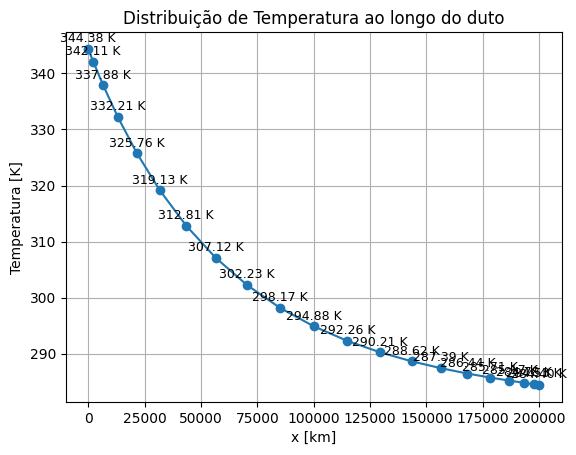

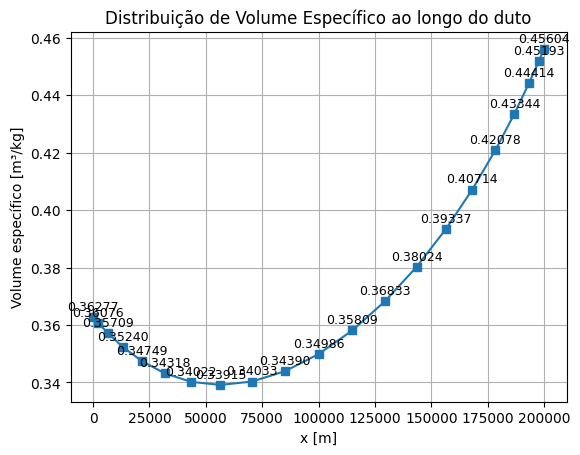

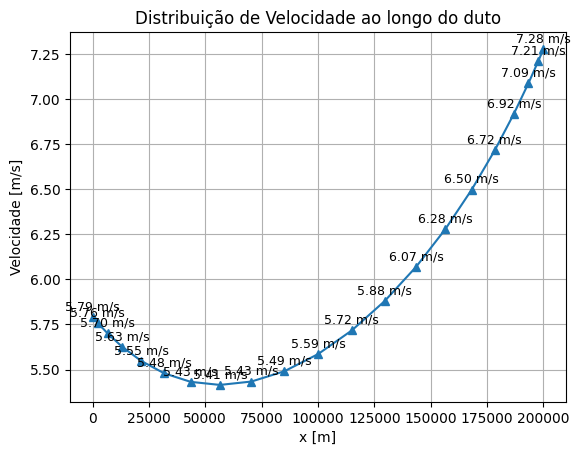

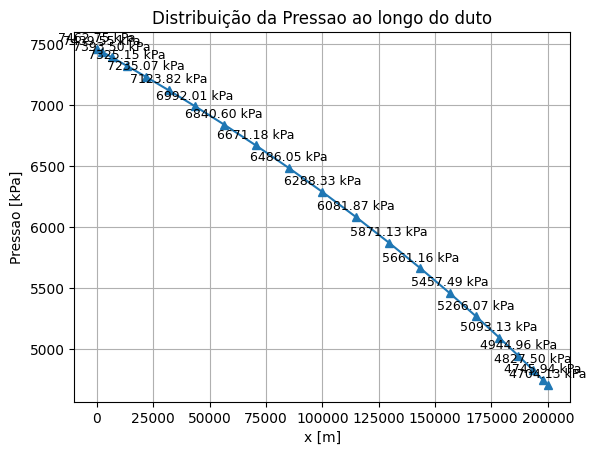

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [ ]:
x0 = np.concatenate([T_sol_estc, V_sol_estc, w_sol_estc])
y0 = [T_sol_estc[-1], V_sol_estc[1], w_sol_estc[-1]]  # estado inicial completo
print(meu_duto.estacionario(0.0, y0))

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Condição inicial (estado estacionário estimado) ---
T0 = T_sol_estc
V0 = V_sol_estc
w0 = w_sol_estc

y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0

# --- Função wrapper para o solve_ivp ---
def dae_wrapper(t, y):
    return meu_duto.evaluate_dae(t, y)

# --- Primeira simulação ---
t_span1 = (0, 100)
t_eval1 = np.linspace(*t_span1, 100)

sol1 = solve_ivp(
    dae_wrapper,
    t_span=t_span1,
    y0=y0,
    method='LSODA',
    t_eval=t_eval1
)

# --- Pegar o estado final da primeira simulação ---
y_final = sol1.y[:, -1]   # vetor (n_nodes * 3,)

In [ ]:
# --- Instancia o modelo ---
meu_sistema = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)

# --- Variáveis simbólicas ---
y = ca.SX.sym("y", 3 * meu_sistema.n_points)   # diferenciais (T, V, w)
z = ca.SX.sym("z", 9)                          # algébricas do compressor (9)
u = ca.SX.sym("u", 3)                          # entrada: rotação
t = ca.SX.sym("t")

# --- Função DAE ---
dydt, alg_eqs = meu_sistema.evaluate_dae(t, y, z, u)
dae_fun = ca.Function("dae_fun", [t, y, z, u], [dydt, alg_eqs])

# --- Integrador CasADi ---
dt = 0.5
dae = {"x": y, "z": z, "p": u, "ode": dydt, "alg": alg_eqs}
integrador = ca.integrator("integrador", "idas", dae, {"tf": dt})

# --- Condições iniciais diferenciais (exemplo) ---
y0 = y_final  # vetor numpy com len = 3 * n_points
u0 = [700.0, 4000, 300]   # rotação inicial
z0 = z_sol

# --- Função para resolver algebraicas ---
# --- Simulação temporal ---
n_steps = 1                
t_sim = np.linspace(0, n_steps * dt, n_steps)
y_sol = np.zeros((n_steps, len(y0)))
z_sol = np.zeros((n_steps, len(z0)))

y_current = y0
z_current = z0
u_current = u0

for i in range(3):
    sol = integrador(x0=y_current, z0=z_current, p=u_current)
    y_current = np.array(sol["xf"]).flatten()
    z_current = np.array(sol["zf"]).flatten()
    print(sol)
    y_sol[i, :] = y_current
    z_sol[i, :] = z_current
# --- Extrair variáveis diferenciais ---
n_points = meu_sistema.n_points
n_t = y_sol.shape[0]

T_sol = np.zeros((n_t, n_points))
V_sol = np.zeros((n_t, n_points))
w_sol = np.zeros((n_t, n_points))

for i in range(n_points):
    T_sol[:, i] = y_sol[:, 3*i + 0]
    V_sol[:, i] = y_sol[:, 3*i + 1]
    w_sol[:, i] = y_sol[:, 3*i + 2]

# --- Plots ---
plt.figure(figsize=(8, 5))
plt.title("Temperatura nos nós do duto")
for i in range(n_points):
    plt.plot(t_sim, T_sol[:, i], label=f"Nó {i+1}")
plt.xlabel("Tempo [s]")
plt.ylabel("Temperatura [K]")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
A = np.pi * (meu_duto.D**2) / 4
MM = meu_duto.gas.mixture.MM_m  # massa molar em kg/mol

# Número de instantes de tempo
n_t = len(sol2.t)

# Inicializa matriz de vazões mássicas (5 nós x n_t tempos)
m_dot = np.zeros((n_nodes, n_t))

# Calcula a vazão mássica para cada nó e tempo
for t_idx in range(n_t):
    for node in range(n_nodes):
        T = sol2.y[0::3][node][t_idx]
        V = sol2.y[1::3][node][t_idx]
        w = sol2.y[2::3][node][t_idx]

        v_kg = V / MM
        rho = 1 / v_kg
        m_dot[node, t_idx] = rho * A * w  # vazão mássica [kg/s]

# Plot da vazão mássica ao longo do tempo para os 5 nós
plt.figure(figsize=(10, 6))
for i in range (n_nodes):
    plt.plot(sol2.t, m_dot[i], label=f'Nó {i}')
plt.xlabel('Tempo [s]')
plt.ylabel('Vazão mássica [kg/s]')
plt.title('Evolução da Vazão Mássica nos 5 Nós')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
plt.show()